# Creating Images From Parametric Galaxies

In this example we show how to create images of parametric galaxies. To make images, we first need to get photometry from an `Sed` on a galaxy. For further details on an `Sed` see the [`Sed` docs](../sed.ipynb) and for galaxies see the [galaxy docs](../galaxies/galaxies.rst).

## The setup

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import Planck18 as cosmo
from synthesizer.filters import UVJ
from synthesizer.grid import Grid
from synthesizer.imaging import ImageCollection
from synthesizer.parametric import SFH, Stars, ZDist
from synthesizer.parametric.galaxy import Galaxy
from synthesizer.parametric.morphology import Sersic2D
from unyt import Myr, degree, kpc

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

# Set the seed
np.random.seed(42)

The first port of call is initilaising the SPS grid. Here we use a simple test grid with limited properties.

In [2]:
# Define the grid
grid_name = "test_grid"
grid_dir = "../../../tests/test_grid/"
grid = Grid(grid_name, grid_dir=grid_dir, new_lam=np.logspace(2, 5, 600))

And we are going to need a set of filters in which to make an image. Here we will use the UVJ function to automatically define a set of UVJ top-hat filters.

In [3]:
# Get a UVJ filter set
filters = UVJ(new_lam=grid.lam)

## Creating the fake galaxy

Now we have intialised the grid we can define the SFZH properties and generate the parametric `Stars` object. First we need to define the SFH and metallicity distribution. There are a number of ways to do this, but for this example we'll use the `SFH` and `ZDist` classes to define a funtional form for each.

In [4]:
# Define the SFH and metallicity distribution
metal_dist = ZDist.DeltaConstant(metallicity=0.01)
sfh_p = {"duration": 100 * Myr}
sfh = SFH.Constant(duration=100 * Myr)

Next, we need to define the morphology of the stellar distribution for our galaxy. Here we will use a Sersic profile which is defined by the effective radius (`r_eff_kpc` if the image will be in physical cartesian units or `r_eff_mas` if the image will be in angular coordinates), the Sersic index (`n`), the ellipticity (`ellip`) and the rotation angle (`theta`). Both the effective radius and rotation angle must be defined with _unyt_ units. The morphology class can convert between cartesian and angular coordinates but only if a cosmology object and redshift of the galaxy is provided.

In [5]:
morph_start = time.time()

# Define the morphology using a simple effective radius and slope
morph = Sersic2D(
    r_eff=5 * kpc, sersic_index=1.0, ellipticity=0.4, theta=1 * degree
)

print("Morphology computed, took:", time.time() - morph_start)

Morphology computed, took: 0.0009572505950927734


Finally, we can pass the SFH and metallicity distribution functions and morphology model to the `Stars` object and get our stellar component.

In [6]:
stars = Stars(
    grid.log10age,
    grid.metallicity,
    sf_hist=sfh,
    metal_dist=metal_dist,
    morphology=morph,
    initial_mass=10**9.5,
)
print(stars)

----------
SUMMARY OF BINNED SFZH
median age: 50.12 Myr
mean age: 50.01 Myr
mean metallicity: 0.0100
----------



With the stellar component defined we can easily intialise the parametric galaxy.

In [7]:
galaxy_start = time.time()

# Initialise a parametric Galaxy with a redshift
galaxy = Galaxy(stars, redshift=5)

print("Galaxy created, took:", time.time() - galaxy_start)

print(galaxy)

Galaxy created, took: 6.723403930664062e-05
-------------------------------------------------------------------------------
                            SUMMARY OF PARAMETRIC GALAXY                           
                           ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣀⣀⡀⠒⠒⠦⣄⡀⠀⠀⠀⠀⠀⠀⠀                          
                           ⠀⠀⠀⠀⠀⢀⣤⣶⡾⠿⠿⠿⠿⣿⣿⣶⣦⣄⠙⠷⣤⡀⠀⠀⠀⠀                          
                           ⠀⠀⠀⣠⡾⠛⠉⠀⠀⠀⠀⠀⠀⠀⠈⠙⠻⣿⣷⣄⠘⢿⡄⠀⠀⠀                          
                           ⠀⢀⡾⠋⠀⠀⠀⠀⠀⠀⠀⠀⠐⠂⠠⢄⡀⠈⢿⣿⣧⠈⢿⡄⠀⠀                          
                           ⢀⠏⠀⠀⠀⢀⠄⣀⣴⣾⠿⠛⠛⠛⠷⣦⡙⢦⠀⢻⣿⡆⠘⡇⠀⠀                          
                           ⠀⠀⠀+-+-+-+-+-+-+-+-+-+-+-+⡇⠀⠀                           
                           ⠀⠀⠀|S|Y|N|T|H|E|S|I|Z|E|R|⠃⠀⠀                           
                           ⠀⠀⢰+-+-+-+-+-+-+-+-+-+-+-+⠀⠀⠀                           
                           ⠀⠀⢸⡇⠸⣿⣷⠀⢳⡈⢿⣦⣀⣀⣀⣠⣴⣾⠟⠁⠀⠀⠀⠀⢀⡎                          
                           ⠀⠀⠘⣷⠀⢻⣿⣧⠀⠙⠢⠌⢉⣛⠛⠋⠉⠀⠀⠀⠀⠀⠀⣠⠎⠀       

And with that galaxy created we can compute the spectra using one of the `galaxy.stars.get_spectra_*` helper methods. Here we compute an integrated intrinsic spectra and then convert the spectra to fluxes.

In [8]:
spectra_start = time.time()

# Generate stellar spectra
sed = galaxy.stars.get_spectra_reprocessed(grid)

# Convert to fluxes
galaxy.get_observed_spectra(cosmo)

print("Spectra created, took:", time.time() - spectra_start)

Spectra created, took: 0.011553049087524414


And then we can calculate the flux in our filters we defined earlier, ready to be passed to the imaging.

In [9]:
phot_start = time.time()

# Generate stellar photometry
galaxy.stars.spectra["intrinsic"].get_photo_fluxes(filters)

print("Photometry calculated, took:", time.time() - phot_start)

Photometry calculated, took: 0.00431370735168457


## Creating the image

To make an image we first need to define the properties of that image including the resolution and FOV. Note that we could also define the number of pixels instead of the FOV, but one of `fov`, or `npix` must be defined, and `resolution` and `fov` must always be given with units.

In [10]:
# Define geometry of the images
fov = 30 * kpc
resolution = fov / 250

print(
    "Image width is %.2f kpc with %.2f kpc resolution"
    % (fov.value, resolution.value)
)

Image width is 30.00 kpc with 0.12 kpc resolution


Now we have all we need to make an image in each filter. To do so we can utilise the `get_imgs_flux` (or `get_imgs_luminosity` for luminosity images) helper method on a `Galaxy` where we simply pass image properties defined above and the type of photometry we want to use (e.g. `"incident"`, `"intrinsic"`, or `"attenuated"`). 

Note, that photometry must have already been generated for the requested `stellar_photometry` type.


In [11]:
img_start = time.time()

img = galaxy.get_images_flux(
    resolution=resolution,
    stellar_photometry="intrinsic",
    fov=fov,
)

print("Images took:", time.time() - img_start)

Images took: 0.004889965057373047


Lets make an RGB image and look at the galaxy we have made.

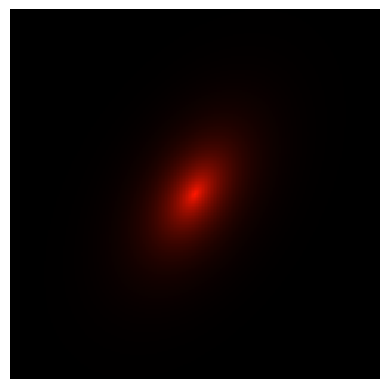

In [12]:
# Make and plot an rgb image
img.make_rgb_image(
    rgb_filters={"R": "J", "G": "V", "B": "U"},
)
fig, ax, _ = img.plot_rgb_image(show=True)

Similarly to the particle images, you can apply PSFs and noise to Parametric images. The process is identical that the method used for particle imaging. For details see the [particle imaging documentation](particle_imaging.ipynb).

## Adding different morphologies together

The galaxy image we created above is very simple, too simple in fact. Real galaxies have different distinct components. To account for this with a parametric galaxy we can create a second galaxy to describe the bulge, since we made a very disky system above. To do so we need to create another fake galaxies with a modified SFZH and morphology, and calculate its spectra and photometry.

In [13]:
# Rename the image
disk_imgs = img

# Define the SFH and metallicity distribution
metal_dist = ZDist.DeltaConstant(metallicity=0.02)
sfh_p = {"peak_age": 200 * Myr, "max_age": 500 * Myr, "tau": 0.5}
sfh = SFH.LogNormal(**sfh_p)  # constant star formation

morph_start = time.time()

# Define the morphology using a simple effective radius and slope
morph = Sersic2D(r_eff=2.5 * kpc, sersic_index=4.0, ellipticity=0, theta=0)

print("Morphology computed, took:", time.time() - morph_start)

# Create the Stars object
stars = Stars(
    grid.log10age,
    grid.metallicity,
    sf_hist=sfh,
    metal_dist=metal_dist,
    morphology=morph,
    initial_mass=10**9,
)
print(stars)

galaxy_start = time.time()

# Initialise a parametric Galaxy
bulge = Galaxy(stars, redshift=5)

print("Bulge created, took:", time.time() - galaxy_start)

spectra_start = time.time()

# Generate stellar spectra
bulge_sed = bulge.stars.get_spectra_reprocessed(grid)

# Convert to fluxes
bulge.get_observed_spectra(cosmo)

print("Spectra created, took:", time.time() - spectra_start)

phot_start = time.time()

# Generate stellar photometry
bulge.stars.spectra["intrinsic"].get_photo_fluxes(filters)

print("Photometry calculated, took:", time.time() - phot_start)

Morphology computed, took: 0.0006999969482421875
----------
SUMMARY OF BINNED SFZH
median age: 199.53 Myr
mean age: 181.62 Myr
mean metallicity: 0.0200
----------

Bulge created, took: 8.845329284667969e-05
Spectra created, took: 0.010547637939453125
Photometry calculated, took: 0.001714944839477539


With the bulge created we can make an image of it in isolation, but this time we will use the lower level imaging methods to demonstrate their usage. We can then plot them using the helper method for individual filter images, for more details on this method see the [particle imaging documentation](particle_imaging.ipynb).

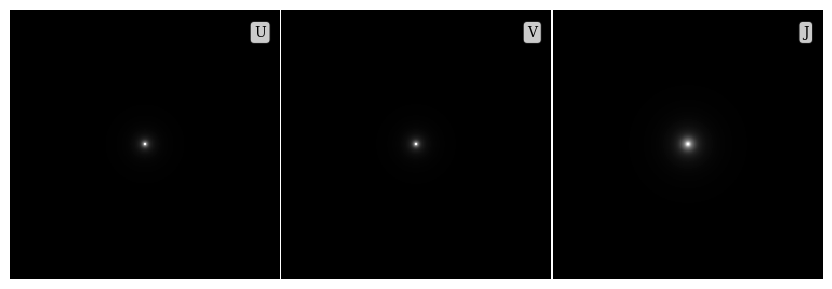

Images took: 0.09561324119567871


In [14]:
img_start = time.time()

# Intialise the Parametric image object
bulge_imgs = ImageCollection(
    resolution=resolution,
    fov=fov,
)

# Compute the photometric images
bulge_imgs.get_imgs_smoothed(
    photometry=bulge.stars.spectra["intrinsic"].photo_fluxes,
    density_grid=bulge.stars.morphology.get_density_grid(
        bulge_imgs.resolution,
        bulge_imgs.npix,
    ),
)

# Lets set up a simple normalisation across all images
vmax = 0
for bimg in bulge_imgs.imgs.values():
    up = np.percentile(bimg.arr, 99.9)
    if up > vmax:
        vmax = up

# Get the plot
fig, ax = bulge_imgs.plot_images(
    show=True, vmin=0, vmax=vmax, scaling_func=np.arcsinh
)
plt.close(fig)

print("Images took:", time.time() - img_start)

Now we need to combine the disk and bulge together into a single image. To do this we simply add together the two `ImageCollection` objects. 

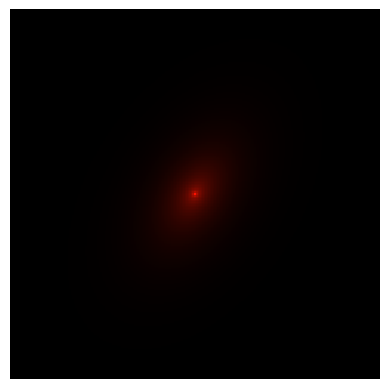

In [15]:
# Combine the images
new_img = disk_imgs + bulge_imgs

# And make a plot
new_img.make_rgb_image(
    rgb_filters={"R": "J", "G": "V", "B": "U"},
)
fig, ax, _ = new_img.plot_rgb_image(show=True)